In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Final_Project_Fall2023/

/content/drive/MyDrive/Final_Project_Fall2023


In [3]:
import pandas as pd
import numpy as np


In [4]:
# Read your data
df = pd.read_csv('eng_french.csv', encoding='utf-8')

# Replace non-breaking spaces with regular spaces
df.replace('\u202F', ' ', regex=True, inplace=True)

df.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


### Data Pre Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from nltk.translate.bleu_score import corpus_bleu

In [6]:
# Load and preprocess data
def load_and_preprocess_data(file_path):
    # Load data
    df = pd.read_csv(file_path)
    english_sentences = df['English words/sentences'].astype(str).tolist()
    french_sentences = df['French words/sentences'].astype(str).tolist()

    # Define maximum sentence length
    max_len = 20

    # Tokenize and pad sentences
    eng_tokenizer = Tokenizer()
    eng_tokenizer.fit_on_texts(english_sentences)
    X = pad_sequences(eng_tokenizer.texts_to_sequences(english_sentences), maxlen=max_len, padding='post')

    fr_tokenizer = Tokenizer()
    fr_tokenizer.fit_on_texts(french_sentences)
    y = pad_sequences(fr_tokenizer.texts_to_sequences(french_sentences), maxlen=max_len, padding='post')

    return train_test_split(X, y, test_size=0.2), eng_tokenizer, fr_tokenizer, max_len

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.initializers import Constant
import numpy as np

def create_model(src_vocab_size, dest_vocab_size, src_timesteps, dest_timesteps, no_units, embedding_matrix):
    model = Sequential()
    model.add(Embedding(src_vocab_size, no_units, embeddings_initializer=Constant(embedding_matrix), input_length=src_timesteps, mask_zero=True, trainable=False))
    model.add(LSTM(no_units))
    model.add(RepeatVector(dest_timesteps))
    model.add(LSTM(no_units, return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(dest_vocab_size, activation='softmax')))
    return model

In [10]:
# Evaluate the model using BLEU score
def evaluate_model(model, X_test, y_test, tokenizer_fr):
    actual, predicted = [], []
    for i, sentence in enumerate(X_test):
        yhat = model.predict(sentence.reshape(1, sentence.shape[0]), verbose=0)
        yhat = np.argmax(yhat, axis=-1)
        translated_sentence = ' '.join([tokenizer_fr.index_word[word] for word in yhat[0] if word != 0])
        actual_sentence = ' '.join([tokenizer_fr.index_word[word] for word in y_test[i] if word != 0])
        actual.append([actual_sentence.split()])
        predicted.append(translated_sentence.split())

    # Calculate BLEU score
    return corpus_bleu(actual, predicted)

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_glove_embeddings(glove_file_path, embedding_dim, word_index):
    # Load GloVe embeddings into a dictionary
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector

    # Prepare the embedding matrix
    num_words = min(len(word_index) + 1, 20000)  # 20000 can be changed based on your vocab size
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= 20000:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in the embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [14]:
# File path to your CSV dataset
file_path = 'eng_french.csv'

# Load and preprocess data
(X_train, X_test, y_train, y_test), tokenizer_eng, tokenizer_fr, max_len = load_and_preprocess_data(file_path)

In [19]:
glove_file_path = 'glove.6B/glove.6B.200d.txt'
embedding_dim = 200  # or 50, 200, 300 depending on your GloVe vectors
embedding_matrix = load_glove_embeddings(glove_file_path, embedding_dim, tokenizer_eng.word_index)

# Model parameters
src_vocab_size = len(tokenizer_eng.word_index) + 1
dest_vocab_size = len(tokenizer_fr.word_index) + 1

print(embedding_matrix.shape,src_vocab_size,200)
# Create and compile the model
model = create_model(src_vocab_size, dest_vocab_size, max_len, max_len, no_units=200,embedding_matrix=embedding_matrix)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Train the model
es = EarlyStopping(monitor='val_loss', patience=3)
lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
history = model.fit(X_train, y_train, epochs=15, batch_size=512, validation_data=(X_test, y_test), callbacks=[es, lr])

# Save the model
model.save('english_to_french_translation_model.h5')

(14532, 200) 14532 200
Epoch 1/15
275/275 [==============================] - 241s 832ms/step - loss: 2.6758 - val_loss: 2.3771 - lr: 0.0010
Epoch 2/15
275/275 [==============================] - 230s 837ms/step - loss: 2.3058 - val_loss: 2.2689 - lr: 9.0000e-04
Epoch 3/15
275/275 [==============================] - 231s 839ms/step - loss: 2.2211 - val_loss: 2.1901 - lr: 8.1000e-04
Epoch 4/15
275/275 [==============================] - 230s 838ms/step - loss: 2.1689 - val_loss: 2.1393 - lr: 7.2900e-04
Epoch 5/15
275/275 [==============================] - 231s 839ms/step - loss: 2.1179 - val_loss: 2.0896 - lr: 6.5610e-04
Epoch 6/15
275/275 [==============================] - 230s 838ms/step - loss: 2.0733 - val_loss: 2.0610 - lr: 5.9049e-04
Epoch 7/15
275/275 [==============================] - 231s 840ms/step - loss: 2.0364 - val_loss: 2.0099 - lr: 5.3144e-04
Epoch 8/15
275/275 [==============================] - 232s 842ms/step - loss: 1.9989 - val_loss: 1.9828 - lr: 4.7830e-04
Epoch 9/15
27

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


BLEU score: 0.026378572991570252


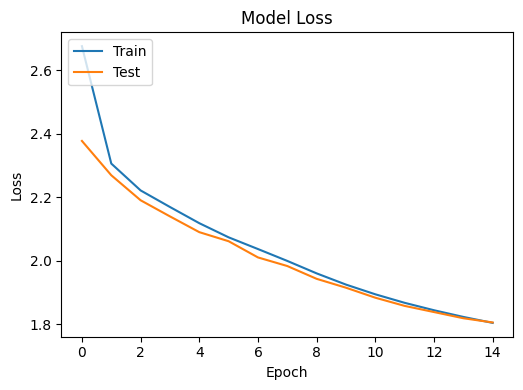

In [25]:

# Evaluate the model
bleu_score = evaluate_model(model, X_test, y_test, tokenizer_fr)
print(f'BLEU score: {bleu_score}')

# Plot training & validation loss values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=29d190200bc1851c3cb013ffde7b33603f88225a25f1fe1688e833b3daa9dc25
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer

def evaluate_model_rouge(model, X_test, y_test, tokenizer_fr):
    actual, predicted = [], []
    for i, sentence in enumerate(X_test):
        yhat = model.predict(sentence.reshape(1, -1))
        yhat = np.argmax(yhat, axis=-1)
        translated_sentence = ' '.join([tokenizer_fr.index_word[word] for word in yhat[0] if word != 0])
        actual_sentence = ' '.join([tokenizer_fr.index_word[word] for word in y_test[i] if word != 0])
        actual.append(actual_sentence)
        predicted.append(translated_sentence)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for ref, hyp in zip(actual, predicted):
        score = scorer.score(ref, hyp)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)

    avg_scores = {key: np.mean(values) for key, values in scores.items()}
    return avg_scores

# Example usage of the evaluate_model_rouge function
rouge_scores = evaluate_model_rouge(model, X_test, y_test, tokenizer_fr)
print(f"ROUGE scores: {rouge_scores}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
ROUGE scores: {'rouge1': 0.14764316169494127, 'rouge2': 0.012325710392013897, 'rougeL': 0.14307657631109452}


In [1]:
from tensorflow.keras.models import load_model

# Path to your .h5 model file
#model_path = 'english_to_french_translation_model.h5'

# Load the model
#model = load_model(model_path)
def translate_sentence(input_sentence, eng_tokenizer, fr_tokenizer, model, max_len):
    # Tokenize and convert to sequence
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    print(input_seq)
    # Pad the sequence
    input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post')
    print(input_seq)
    # Predict the output sequence
    prediction = model.predict(input_seq)
    for word in prediction[0]:
      print(np.argmax(word),word)
    # Convert prediction to words
    predicted_sentence = ' '.join([fr_tokenizer.index_word[np.argmax(word)] for word in prediction[0] if np.argmax(word) != 0])
    return predicted_sentence

# Example usage
print(tokenizer_eng)
input_sentence = "It's me"
translated_sentence = translate_sentence(input_sentence, tokenizer_eng, tokenizer_fr, model, max_len)
print(f"Translated Sentence: {translated_sentence}")

NameError: name 'tokenizer_eng' is not defined